
**Introduction**
---


In this notebook, I will employ Neural Style Transfer to create visual content.

In this deep learning technique, a neural network takes two images (or three, if we count the input image), one being the content image which we want to stylize and the other being style image, which is the basis of style. 

The neural network then optimizes three loss functions Lcontent, Lstyle and Ltotal variation, to preserve content, stylistic features and spatial continuity respectively. 

Content is the collection of higher level features; such as curves, edges and contours, i.e. the shapes that define an object. These are extracted features from the convolutional layer.

Style on the other hand is thought of as joint statistics of flattened extracted features, represented in the form of a Gram matrix (more on that later). Similar images will have similar Gram matrices, so they will have similar styles. Style mostly refers to texture, which is in fact at a lower level, thus it is represented mostly by the outputs of earlier convolutional layers.

The neural style transfer algorithm optimizes the following cost function:

- *Loss = alpha * Content Loss(Seed Image - Content Image) + beta * Style Loss(Seed Image - Style Image)*

in which

-  *Content Loss = (Feature map of Input Image - Feature map of Content Image) ** 2*
- *Style Loss = (Gram matrix of Input Image - Gram matrix of Style Image) ** 2*

where alpha and beta are hyperparameters that define which loss function has a higher weight.


**Import dependencies**

In [ ]:
import regex as re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display
import time
import matplotlib.pyplot as plt
import tensorflow.signal as sp
from skimage import measure

**Regex-based processor to generate paths for newly created images**

In [ ]:
def modify_path_name(path, modification):
  path_chunks = re.split("\.", path)
  path_chunk_until_title = re.split("\.", base_image_path)[0:len(re.split("\.", base_image_path))-2]
  title_chunk =  path_chunks[-2]
  extension_chunk = "." + path_chunks[-1]
  new_path = ""
  for string in path_chunk_until_title:
    new_path += string
  new_path += (title_chunk+modification)
  new_path += extension_chunk
  return str(new_path)

# Functions and Data Representation

**Preprocessing utility methods**

One should first preprocess a given image to a tensor for numerical operations to be performed on them. The function preprocess_image is the following algorithm:
1. Turns the image to a numpy array
2. Expands the dimensions for batching
3. Channel order is changed from RGB to BGR.
4. Each color center is zero-centered, that is, from each pixel value the mean is subtracted.
5. The processed numpy array is converted to the tensor format.

After the images are processed, othese tensors are converted back to images with the following procedure:
1. Tensor is reshaped to predetermined rows, columns and channels.
2. Zero-centering is reversed by adding the values to each pixel. In this example the numbers set are already known, as the zero-centering was done with respect to the mean known from ImageNet dataset.
3. Color channel order is converted back to RGB from BGR.
4. The values are clipped, that is, confined to a range between 0-255, as unsigned 8-bit integer form.

In [ ]:
def preprocess_image(image_path):
  image = keras.preprocessing.image.load_img(image_path, target_size=(nrows, ncols))
  image = keras.preprocessing.image.img_to_array(image)
  image = np.expand_dims(image, 0)
  image = vgg19.preprocess_input(image)
  image = tf.convert_to_tensor(image)
  tf.cast(image, tf.float32)
  return image

def deprocess_image(tensor):
  tensor = tensor.reshape((nrows, ncols, 3))
  tensor[:, :, 0] +=  103.939
  tensor[:, :, 1] +=  116.779
  tensor[:, :, 2] +=  123.68
  tensor = tensor[:, :, ::-1]
  tensor = np.clip(tensor, 0, 255).astype("uint8")
  return tensor 


**Function for video style transfer**

This function:
1. Gets a video
2. Processes it to tensors
3. Feeds each video to style transfer
4. Collects the style-transferred frames
5. Writes each frame to a video and returns it.


**Functions for Gram matrix, total variation loss, style loss and content loss**

Style can be thought of as features that occur together, i.e. different styles would have different correlations between each feature. Gram matrix is the transpose of feature vectors over themselves, effectively calculating correlations.



In [ ]:
def gram_matrix(tensor):
  tensor = tf.transpose(tensor, (2, 0, 1))
  features = tf.reshape(tensor, (tf.shape(tensor)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

def total_variation_loss(x):
  tf.cast(x, tf.int32)
  a = tf.square(x[:, : nrows - 1, : ncols - 1, :] - x[:, 1:, : ncols - 1, :])
  b = tf.square(x[:, : nrows - 1, : ncols - 1, :] - x[:, : nrows - 1, 1:, :])
  
  return tf.reduce_sum(tf.pow(a+b,1.25))

def style_transfer_loss(style, combination):
  gram_S = gram_matrix(style)
  gram_C = gram_matrix(combination)
  channels = 3
  size = nrows * ncols
  return tf.reduce_sum(tf.square(gram_S - gram_C)/(4.0 * (channels ** 2) * (size ** 2)))

def content_transfer_loss(base, combination):
  return tf.reduce_sum(tf.square(base-combination))

# Model Architecture

**Feature extraction model**

In [ ]:
# VGG19 model is a common CNN, here its ImageNet trained version was chosen
model = vgg19.VGG19(weights="imagenet", include_top=False)
# Iterate through the layers of the model, creating a dictionary in which
# layer names are keys and layer outputs (features) are values
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**Layers for defining style and content transfer loss**

Loss functions take the outputs of convolutional layers as variables. Style layers are taken into account while adjusting style and content layers to the same for content. As the earlier layers of a CNN extract lower level features they represent texture,rather than content. Content is a higher level feature and it is captured better in final layers, rather than the earlier ones. Hence, "block5_conv2" is chosen as content layer, while the others are chosen for style.

In [ ]:
style_layer_names = ["block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",]

content_layer_name = "block5_conv2"

**Computation of loss**

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image, weights=(6e-8, 6e-8, 6e-8)):
    """
    Computes loss. Weights are in content, style, total variation order.
    """
    content_weight, style_weight, total_variation_weight = weights
    # Aggregate all tensors to an input tensor
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    # Feature extractor here 
    features = feature_extractor(input_tensor)

    # Initialize the loss, which is a tensor full of zeros
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * content_transfer_loss(
        base_image_features, combination_features
    )

    # Add style loss
    # This loop iterates through the given layers from VGG19s convolutional layers:
    for layer_name in style_layer_names:
        # Iterates through the layers which represent style (texture)
        layer_features = features[layer_name]
        # Gets features from the layer
        style_reference_features = layer_features[1, :, :, :]
        # Gets features from the combination image 
        combination_features = layer_features[2, :, :, :]
        # and calculates style transfer loss for each layer 
        sl = style_transfer_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

def compute_loss_with_entropy(combination_image, base_image, style_reference_image):
  """ Computes a custom loss over which is already given in the vanilla model """
  main_loss = compute_loss(combination_image, base_image, style_reference_image, weights=(6e-8, 6e-8, 6e-8))
  entropy_loss = (measure.entropy.shannon_entropy(base_image) - measure.entropy.shannon_entropy(combination_image)) ** 2
  return main_loss + entropy_loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image, weights):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image, weights)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

def compute_loss_and_grads_with_entropy(combination_image, base_image, style_reference_image, weights):
    with tf.GradientTape() as tape:
        loss = compute_loss_with_entropy(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

**Optimization of transfer loss function (the training loop)**

In [ ]:
def style_transfer_training_loop(base_image_path, style_reference_image_path, n_iterations, weights, optimizer):
  """ A modularized version of basic style transfer process, perhaps can be integrated
  with a class that inherits from keras.Model as a standalone style transfer model. 
  """
  base_image = preprocess_image(base_image_path)
  style_reference_image = preprocess_image(style_reference_image_path)
  combination_image = tf.Variable(preprocess_image(base_image_path))

  new_image_path = "/content/new_image_generated_sgd.jpg"
  print("Saving generated image to the following path: ", new_image_path)
  
  print("Done preprocessing images.")

  iterations = n_iterations

  print("Whole training loop has started.")
  start_time = time.time()

  for i in range(1, iterations + 1):

      print("Loop number ", i, " has started.")
      loop_start_time = time.time()

      loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image, weights)
      optimizer.apply_gradients([(grads, combination_image)])

      print("Iteration number ", i, " has ended.")
      print("Recorded iteration duration: ", time.time()-loop_start_time, " seconds.")

      generated_img = deprocess_image(combination_image.numpy())
      # Visualize the process
      keras.preprocessing.image.save_img(new_image_path, generated_img)
  
  print("Recorded training duration: ", (time.time()-start_time)/60 , " mins")
  print("Image generated.")  
  
  
  return generated_img, new_image_path

def style_transfer_training_loop_with_entropy(base_image_path, style_reference_image_path, n_iterations, weights, optimizer):
  """ Same as the style transfer training loop but with entropy added in the loss function. """
  base_image = preprocess_image(base_image_path)
  style_reference_image = preprocess_image(style_reference_image_path)
  combination_image = tf.Variable(preprocess_image(base_image_path))

  new_image_path = "/content/new_image_generated_sgd_with_entropy.jpg"
  print("Saving generated image to the following path: ", new_image_path)
  
  print("Done preprocessing images.")

  iterations = n_iterations

  print("Whole training loop has started.")
  start_time = time.time()

  for i in range(1, iterations + 1):

      print("Loop number ", i, " has started.")
      loop_start_time = time.time()

      loss, grads = compute_loss_and_grads_with_entropy(combination_image, base_image, style_reference_image, weights)
      optimizer.apply_gradients([(grads, combination_image)])

      print("Iteration number ", i, " has ended.")
      print("Recorded iteration duration: ", time.time()-loop_start_time, " seconds.")

      generated_img = deprocess_image(combination_image.numpy())
      # Visualize the process
      keras.preprocessing.image.save_img(new_image_path, generated_img)
  
  print("Recorded training duration: ", (time.time()-start_time)/60 , " mins")
  print("Image generated.")  
  
  
  return generated_img, new_image_path

# Interfacing 

**Image paths:** 

Image data are pulled from these links.

In [ ]:
base_image_path = "/content/us.jpg" 
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
 
 
print("Base image path: ", base_image_path)
print("Texture image path: ", style_reference_image_path)

Base image path:  /content/us.jpg
Texture image path:  /root/.keras/datasets/starry_night.jpg


**Dimensions of generated image**

In [ ]:
width, height = keras.preprocessing.image.load_img(base_image_path).size
nrows = 500
ncols = int(width * nrows / height)

**Display and examine the images**

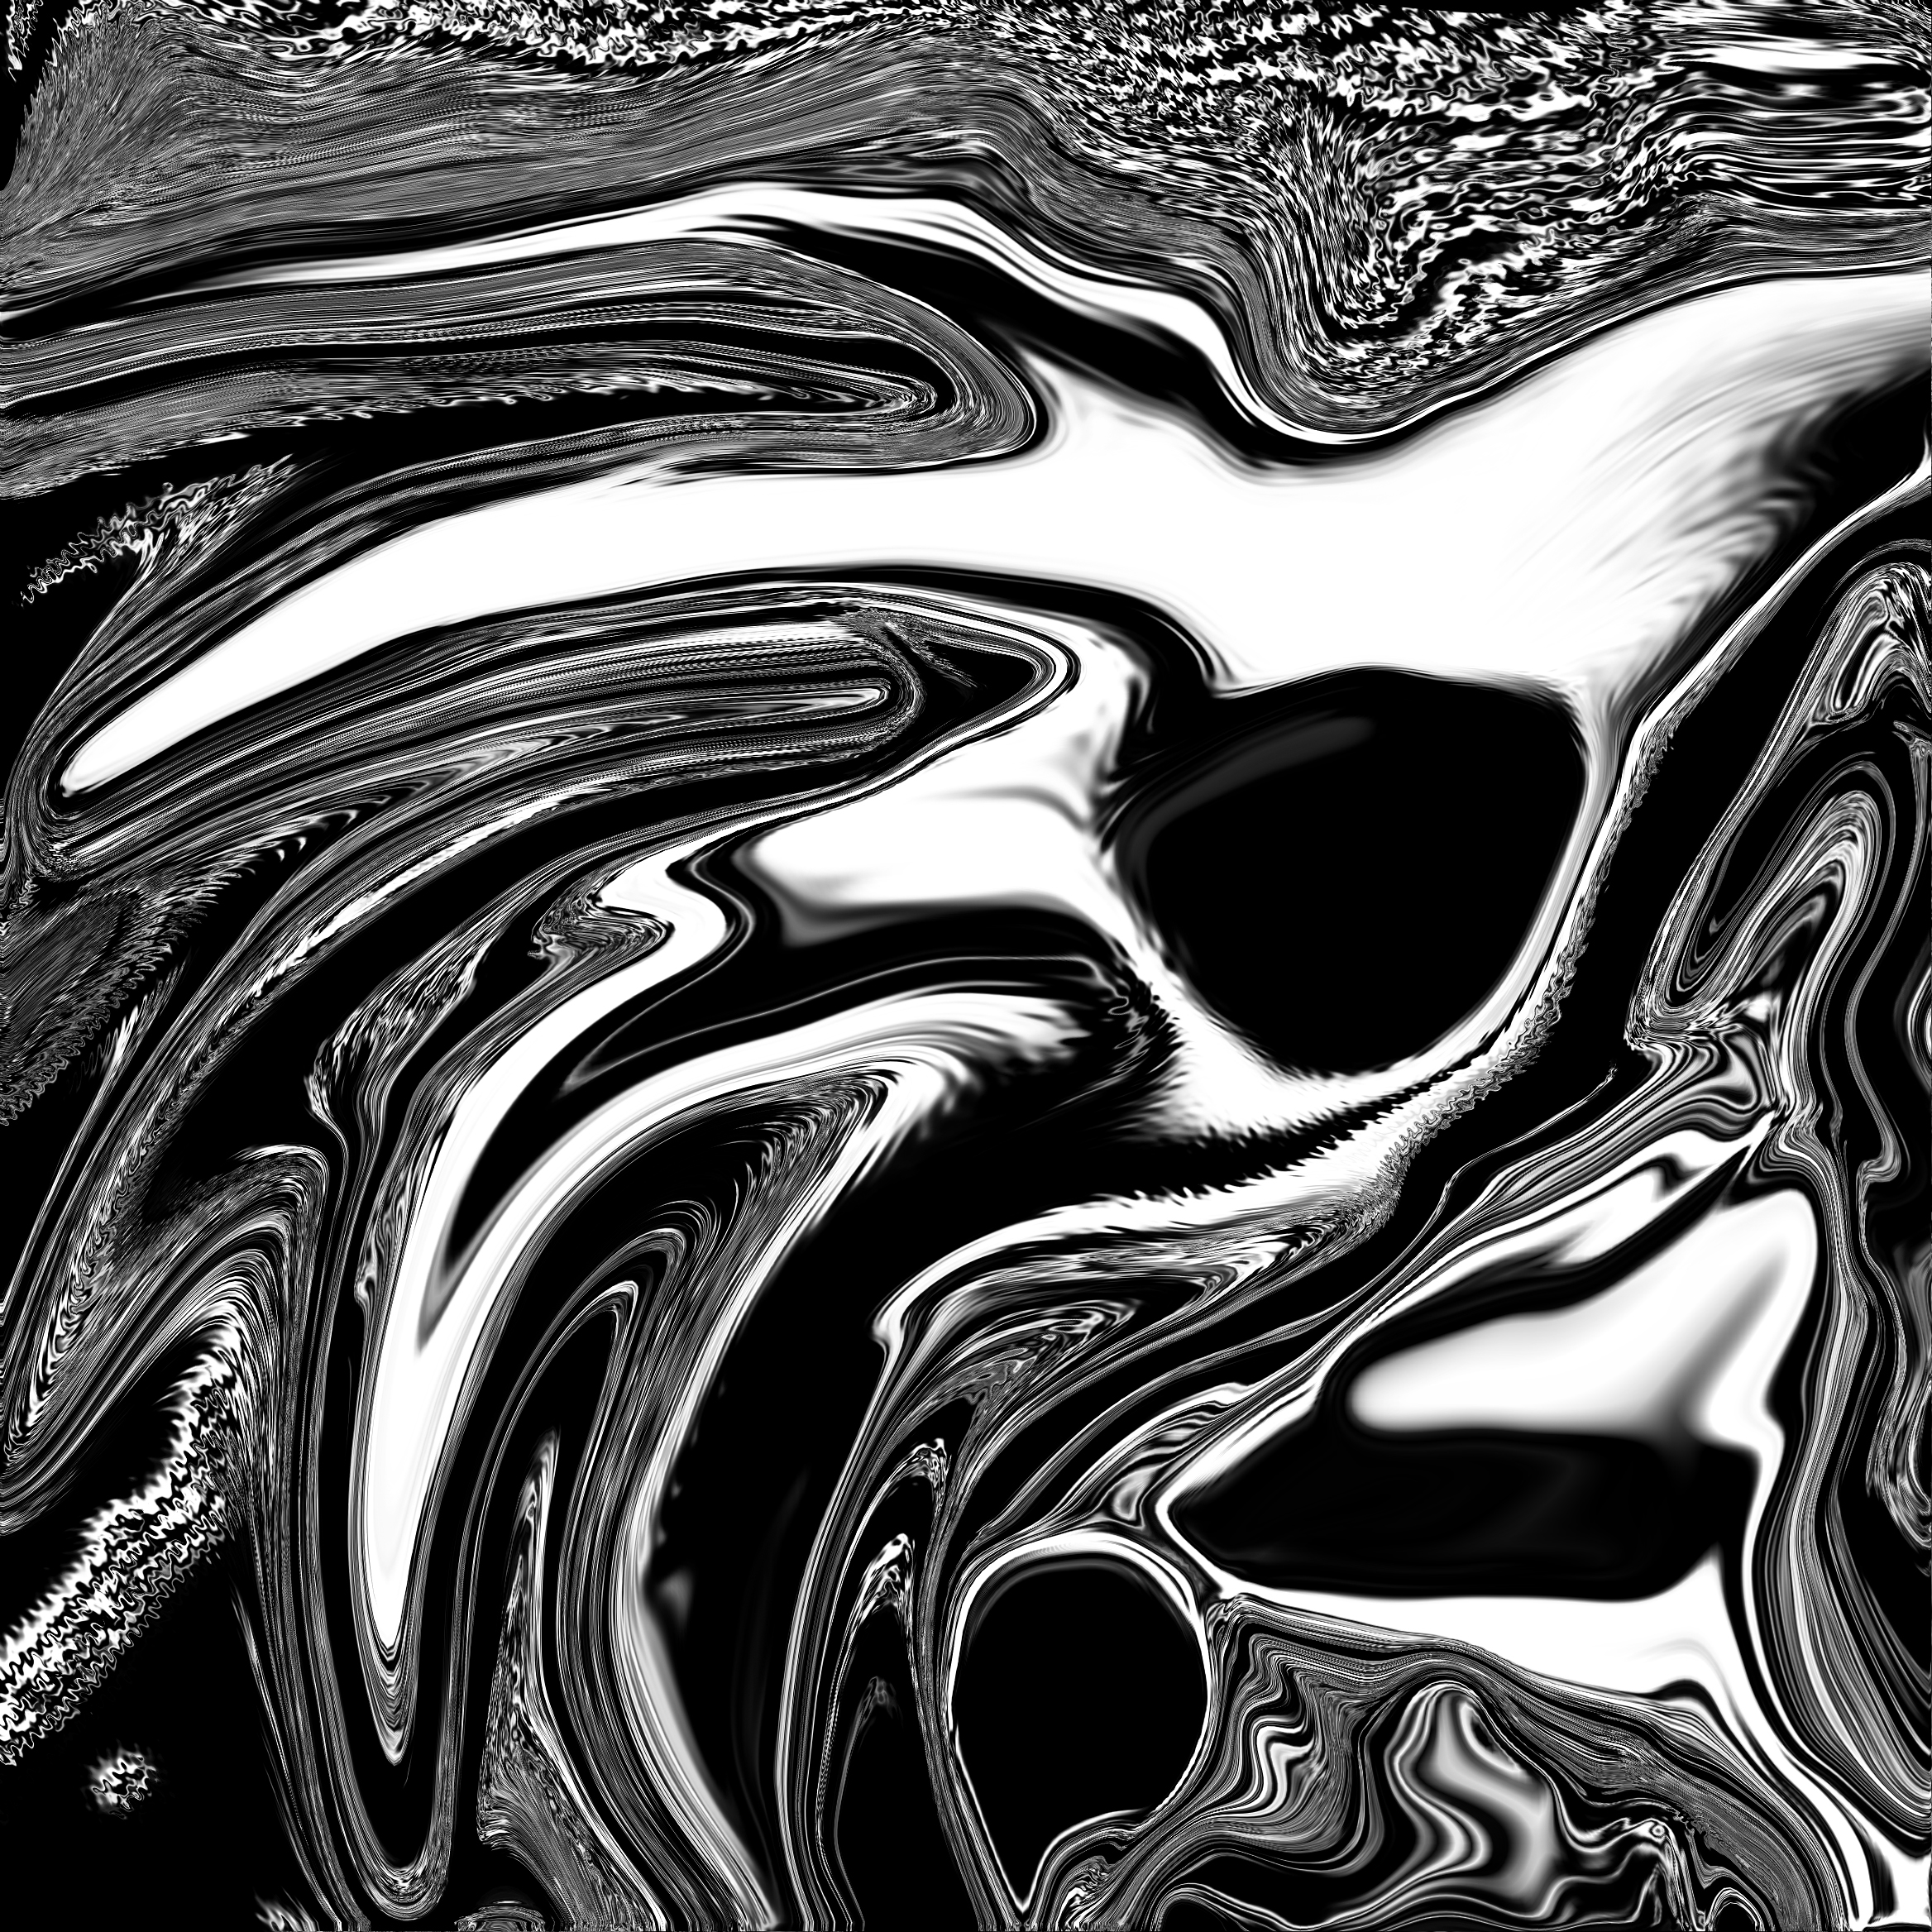

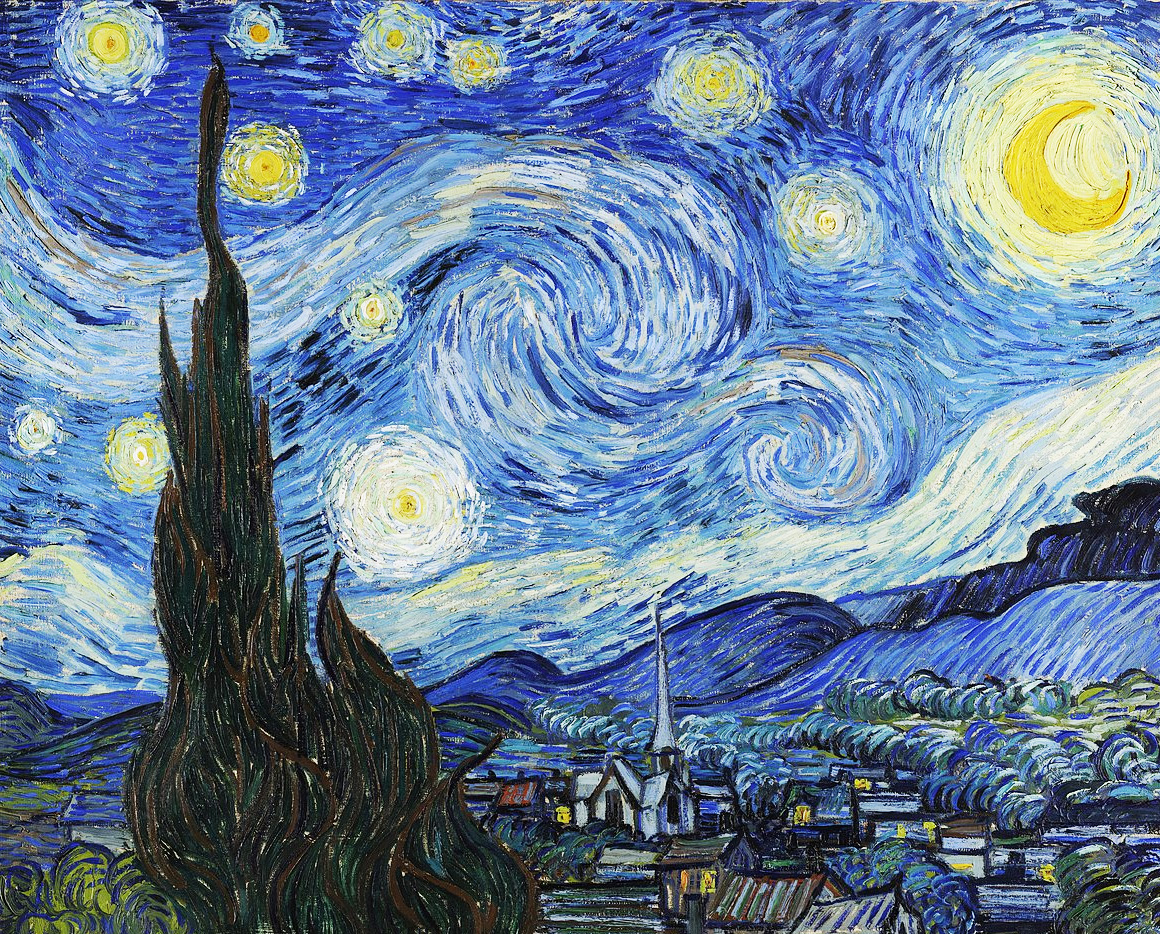

In [ ]:
display(Image(base_image_path))
display(Image(style_reference_image_path))

# Analysis of Algorithm Performance 

**Transfer Computation Speed Comparison**

Here I will compare how long does processing the image take with respect to
- Different learning rate adjustments
- Different optimization functions


In [ ]:
# Schedule parameters for ExponentialDecay
# Learning rate - decay steps - decay rate
parameters_1 = (100.0, 100, 0.95)
parameters_2 = (50.0, 50, 0.50)
# Learning rate - decay steps
parameters_3 = (100.0, 100)
parameters_4 = (100.0, 50)
# Initialize schedule objects: 
# Each of these are different schedules for adjustments of learning rate. 
schedule_1 = keras.optimizers.schedules.ExponentialDecay(*parameters_1)
schedule_2 = keras.optimizers.schedules.ExponentialDecay(*parameters_2)
schedule_3 = keras.optimizers.schedules.CosineDecay(*parameters_3)
schedule_4 = keras.optimizers.schedules.CosineDecay(*parameters_4)
# Comparison of different optimizers with same and different schedules
optimizer_1 = keras.optimizers.SGD(schedule_1)
optimizer_2 = keras.optimizers.SGD(schedule_2)
optimizer_3 = keras.optimizers.SGD(schedule_3)
optimizer_4 = keras.optimizers.SGD(schedule_4)
optimizer_5 = keras.optimizers.Adam(0.001, 0.5, 1.0)
optimizer_6 = keras.optimizers.Adam(0.001, 1.0, 1.0)

Testing between different parameters of stochastic gradient descent and counting how many second each ran.
First time (2e-1, 2e-10, 6e-1)
Second time (2e-1, 2e-10, 6e-3)
Third time (2e-1, 2e-10, 6e-5)
- optimizer_1: 0.900, 0.906, 0.926 mins
- optimizer_2: 0.886, 0.887, 0.942 mins
- optimizer_3: 0.889, 0.884, mins
- optimizer_4: 0.885, 0.899, mins

**Comparison of Image Statistics With Respect to Different Style Transfer Parameters**

Here I will compare changes in combination image characteristics with respect to 
- Different style transfer parameters:
1. Optimization algorithms
2. Loss weights
3. Number of iterations
4. Input image dimensions

Characteristics that are quantitatively examined:
1. Difference in entropy between base and combination images
2. Base image / combination image entropy ratio
3. Style image / combination image entropy ratio
4. Image histograms
5. 2-D real fourier transform of the base image and combination image




In [ ]:
generated_img, _ = style_transfer_training_loop(base_image_path, style_reference_image_path, 50, (2e-2, 8e-5, 2e-10) , optimizer_4)
generated_img2, _ = style_transfer_training_loop_with_entropy(base_image_path, style_reference_image_path, 10, (2e-5, 8e-6, 2e-10) , optimizer_4)

Saving generated image to the following path:  /content/new_image_generated_sgd.jpg
Done preprocessing images.
Whole training loop has started.
Loop number  1  has started.
Iteration number  1  has ended.
Recorded iteration duration:  5.208745241165161  seconds.
Recorded training duration:  0.08733213742574056  mins
Image generated.
Saving generated image to the following path:  /content/new_image_generated_sgd_with_entropy.jpg
Done preprocessing images.
Whole training loop has started.
Loop number  1  has started.
Iteration number  1  has ended.
Recorded iteration duration:  1.3080687522888184  seconds.
Loop number  2  has started.
Iteration number  2  has ended.
Recorded iteration duration:  0.2762753963470459  seconds.
Loop number  3  has started.
Iteration number  3  has ended.
Recorded iteration duration:  0.2790718078613281  seconds.
Loop number  4  has started.
Iteration number  4  has ended.
Recorded iteration duration:  0.27690839767456055  seconds.
Loop number  5  has started

In [ ]:
base_image_entropy = measure.entropy.shannon_entropy(preprocess_image(base_image_path))
style_image_entropy = measure.entropy.shannon_entropy(preprocess_image(style_reference_image_path))
generated_image_entropy = measure.entropy.shannon_entropy(generated_img)
generated_image_entropy_experimental = measure.entropy.shannon_entropy(generated_img2)

In [ ]:
print("Base image shannon entropy: ", base_image_entropy)
print("Style reference image entropy: ", style_image_entropy)
print("Generated image entropy: ", generated_image_entropy)
print("Generated image entropy with custom loss: ", generated_image_entropy_experimental)

Base image shannon entropy:  7.471039363984015
Style reference image entropy:  9.428616939598045
Generated image entropy:  3.467331060373201
Generated image entropy with custom loss:  6.472806572110198


References

[0] https://arxiv.org/abs/1508.06576

[1] https://gcamp6f.com/2017/12/05/understanding-style-transfer/

[2] https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

[3] https://arxiv.org/pdf/1701.01036.pdf

[4] https://keras.io/examples/generative/neural_style_transfer/

[5] https://iq.opengenus.org/vgg19-architecture/

[6] https://medium.com/analytics-vidhya/understanding-and-implementing-neural-style-transfer-7d752d3cfe74

